In [1]:
import json
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from scipy import stats

def load_data(results_dir):
    data = []
    with open("../models.json") as f:
        model_list = json.load(f)["models"]
    benchmarks = ['defects4j', 'gitbugjava']
    metrics = ['ast_match@1', 'plausible@1']

    for llm_name, strategy, provider in model_list:
        row = {'name': llm_name, 'provider': provider, 'total_cost': 0}

        try:
            with open(f"{results_dir}/{llm_name}/total.json") as f:
                total_result = json.load(f)
                row['total_ast_match@1'] = total_result.get('ast_match@1', None)
                row['total_plausible@1'] = total_result.get('plausible@1', None)
                row['total_cost'] = total_result.get('cost', 0)
                row['total_num_bugs_with_ast_match_candidates'] = total_result.get('num_bugs_with_ast_match_candidates', 0)
                row['total_num_bugs_with_plausible_candidates'] = total_result.get('num_bugs_with_plausible_candidates', 0)
                row['total_greedy_ast_match@10'] = row['total_num_bugs_with_ast_match_candidates'] / 574
                row['total_greedy_plausible@10'] = row['total_num_bugs_with_plausible_candidates'] / 574
        except FileNotFoundError:
            print(f"Warning: total.json not found for {llm_name}")
            row['total_ast_match@1'] = None
            row['total_plausible@1'] = None

        for benchmark in benchmarks:
            try:
                with open(f"{results_dir}/{llm_name}/{benchmark}/statistics_{benchmark}_instruct_{strategy}.json") as f:
                    stats_result = json.load(f)
                    for metric in metrics:
                        row[f"{benchmark}_{metric}"] = stats_result.get(metric, None)

                with open(f"{results_dir}/{llm_name}/{benchmark}/usage_{benchmark}_instruct_{strategy}.json") as f:
                    cost_result = json.load(f)
                    row[f"{benchmark}_cost"] = cost_result.get('total_cost', 0)
                    row['total_cost'] += cost_result.get('total_cost', 0)
            except FileNotFoundError:
                print(f"Warning: Data not found for {llm_name} - {benchmark}")
                for metric in metrics:
                    row[f"{benchmark}_{metric}"] = None
                row[f"{benchmark}_cost"] = None

        data.append(row)

    return data

# Load the data
results_dir = os.path.join("..", 'results')
data = load_data(results_dir)

# Create a DataFrame
df = pd.DataFrame(data)

In [2]:
def find_pareto_frontier(costs, performances):
    """
    Finds the Pareto frontier for a set of points.
    Assumes lower cost is better and higher performance is better.

    Args:
        costs (list or pd.Series): List of costs.
        performances (list or pd.Series): List of performances.

    Returns:
        list: A list of tuples (cost, performance) representing the Pareto frontier,
              sorted by cost.
    """
    points = list(zip(costs, performances))
    pareto_points_set = set() # Use a set to avoid duplicates initially

    for i, p1 in enumerate(points):
        c1, perf1 = p1
        is_pareto = True
        for j, p2 in enumerate(points):
            if i == j:
                continue
            c2, perf2 = p2
            # Check if point j dominates point i
            if c2 <= c1 and perf2 >= perf1 and (c2 < c1 or perf2 > perf1):
                is_pareto = False
                break
        if is_pareto:
            pareto_points_set.add(p1)

    # Convert set to list and sort by cost for plotting
    pareto_points = sorted(list(pareto_points_set))
    return pareto_points


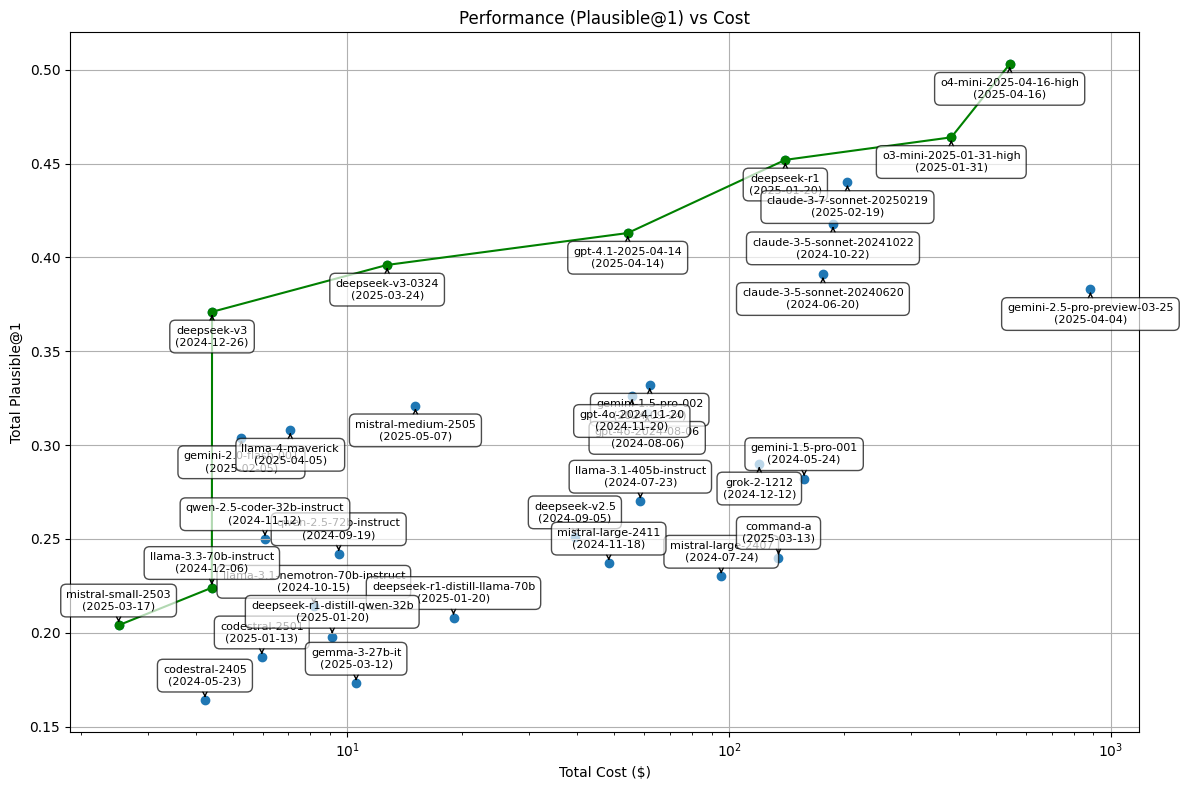

In [3]:
# Create a scatter plot of performance per cost
plt.figure(figsize=(12, 8))
scatter = plt.scatter(df['total_cost'], df['total_plausible@1'])

# Define a dictionary with release dates for each model
with open('../results/release_dates.json') as f:
    release_dates = json.load(f)

# Drop rows with missing data
df_total = df.dropna(subset=['total_cost', 'total_plausible@1'])
df_total = df_total.dropna(subset=['total_cost', 'total_ast_match@1'])

pareto_plausible = find_pareto_frontier(df_total['total_cost'], df_total['total_plausible@1'])
pareto_costs_plausible, pareto_perf_plausible = zip(*pareto_plausible)

# Add labels for each point with release dates
for i, row in df_total.iterrows():
    model_name = row['name']
    release_date = release_dates.get(model_name, 'N/A')
    
    label = f"{model_name}\n({release_date})"
    x, y = row['total_cost'], row['total_plausible@1']
    
    # Adjust the position of the label to stay within the plot
    ha = 'center'
    va = 'bottom' if y < df_total['total_plausible@1'].median() else 'top'
    xytext = (0, 10) if va == 'bottom' else (0, -10)
    
    plt.annotate(label, (x, y), 
                 xytext=xytext, textcoords='offset points', 
                 ha=ha, va=va, fontsize=8, 
                 bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.7),
                 arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

plt.plot(pareto_costs_plausible, pareto_perf_plausible, marker='o', linestyle='-', color='g', label='Pareto Frontier')

plt.xlabel('Total Cost ($)')
plt.xscale('log')
plt.ylabel('Total Plausible@1')
plt.title('Performance (Plausible@1) vs Cost')

plt.grid(True)

# Adjust the plot layout to make room for annotations
plt.tight_layout()

# Save as pdf
plt.savefig('performance-vs-cost.pdf', format='pdf', bbox_inches='tight')
plt.savefig('performance-vs-cost.png', format='png', bbox_inches='tight')

plt.show()

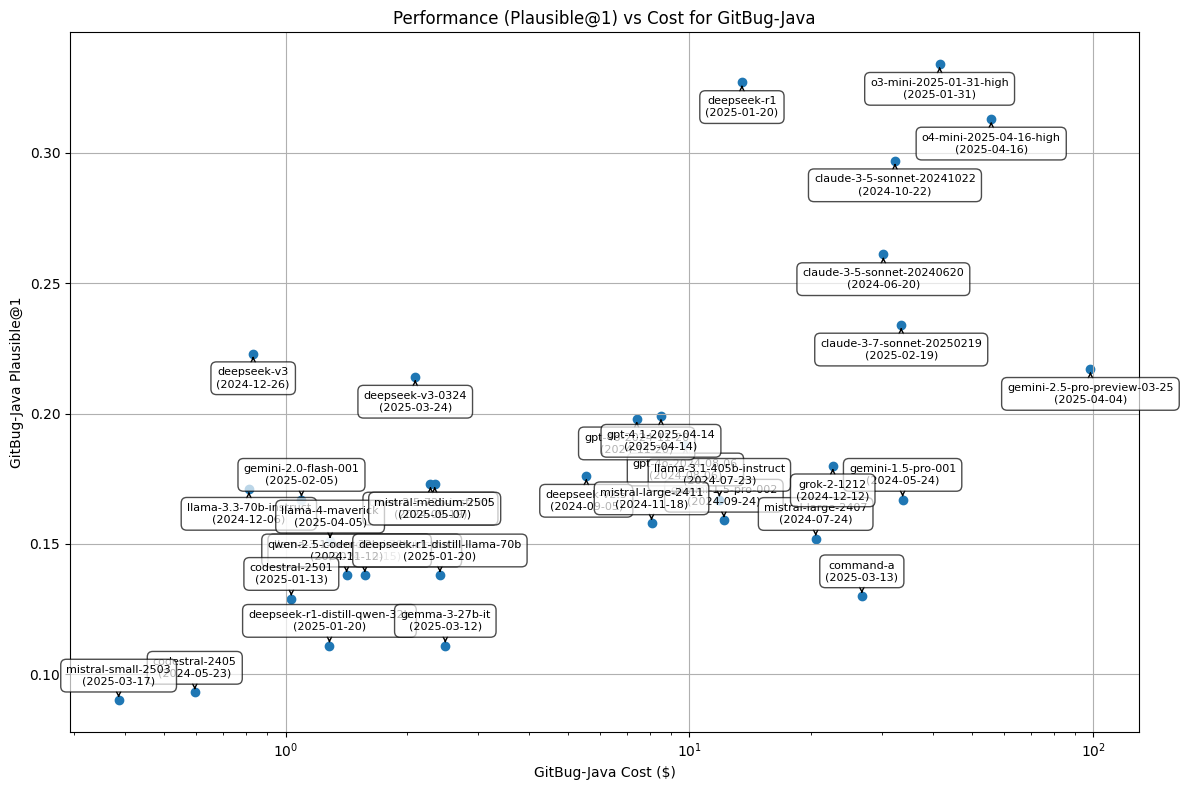

In [4]:
# Create a scatter plot of performance per cost
plt.figure(figsize=(12, 8))
scatter = plt.scatter(df['gitbugjava_cost'], df['gitbugjava_plausible@1'])

# Define a dictionary with release dates for each model
with open('../results/release_dates.json') as f:
    release_dates = json.load(f)

# Add labels for each point with release dates
for i, row in df.iterrows():
    model_name = row['name']
    release_date = release_dates.get(model_name, 'N/A')
    
    label = f"{model_name}\n({release_date})"
    x, y = row['gitbugjava_cost'], row['gitbugjava_plausible@1']
    
    # Adjust the position of the label to stay within the plot
    ha = 'center'
    va = 'bottom' if y < df['gitbugjava_plausible@1'].median() else 'top'
    xytext = (0, 10) if va == 'bottom' else (0, -10)
    
    plt.annotate(label, (x, y), 
                 xytext=xytext, textcoords='offset points', 
                 ha=ha, va=va, fontsize=8, 
                 bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.7),
                 arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

plt.xlabel('GitBug-Java Cost ($)')
plt.xscale('log')
plt.ylabel('GitBug-Java Plausible@1')
plt.title('Performance (Plausible@1) vs Cost for GitBug-Java')

plt.grid(True)

# Adjust the plot layout to make room for annotations
plt.tight_layout()

# Save as pdf
plt.savefig('performance-vs-cost-gitbugjava.pdf', format='pdf', bbox_inches='tight')
plt.savefig('performance-vs-cost-gitbugjava.png', format='png', bbox_inches='tight')

plt.show()

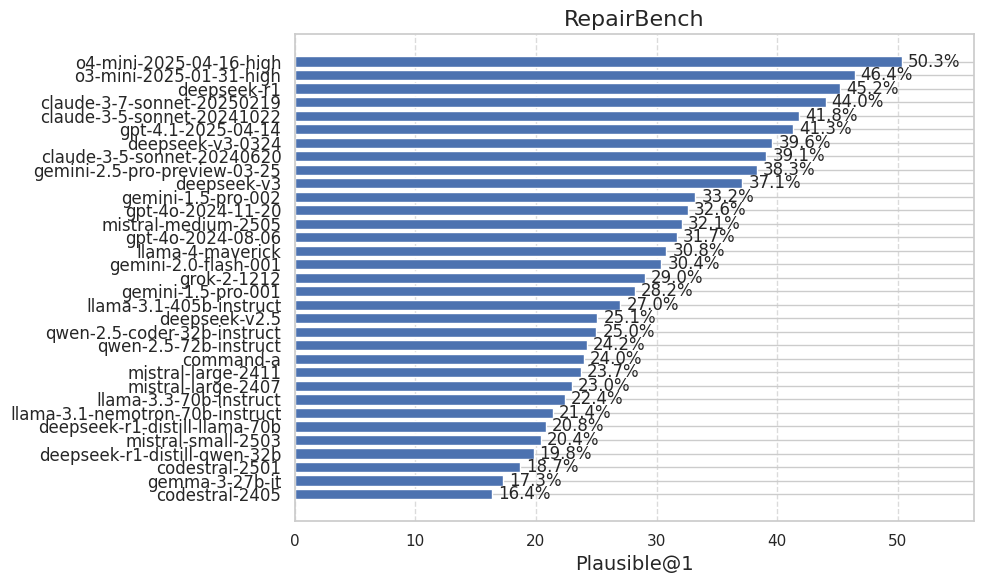

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sort the DataFrame by 'total_plausible@1' in descending order
df_sorted = df.sort_values(by='total_plausible@1', ascending=True)

# Remove rows with missing data
df_sorted = df_sorted.dropna(subset=['total_plausible@1'])

# Set a style
sns.set(style="whitegrid")

# Create a horizontal bar plot with a single color
plt.figure(figsize=(10, 6))
bars = plt.barh(df_sorted['name'], df_sorted['total_plausible@1'] * 100, align="center", height=0.75)  # Reduced height

# Set labels and title with improved font size and bold text
plt.xlabel('Plausible@1', fontsize=14)
plt.title('RepairBench', fontsize=16)

# Add text annotations to display the exact score at the end of each bar with some space and bold text
for bar in bars:
    plt.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2, f'{bar.get_width():.1f}%', va='center', fontsize=12)

# Adjust x-axis limits to provide extra space on the right side
plt.xlim(0, df_sorted['total_plausible@1'].max() * 100 + 6)

# Add a grid for better readability
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Make the names bold
plt.yticks(fontsize=12)

# Adjust layout to make room for the labels
plt.tight_layout()

# Save as pdf
plt.savefig('box-plot.pdf', format='pdf', bbox_inches='tight')
plt.savefig('box-plot.png', format='png', bbox_inches='tight')

# Display the plot
plt.show()

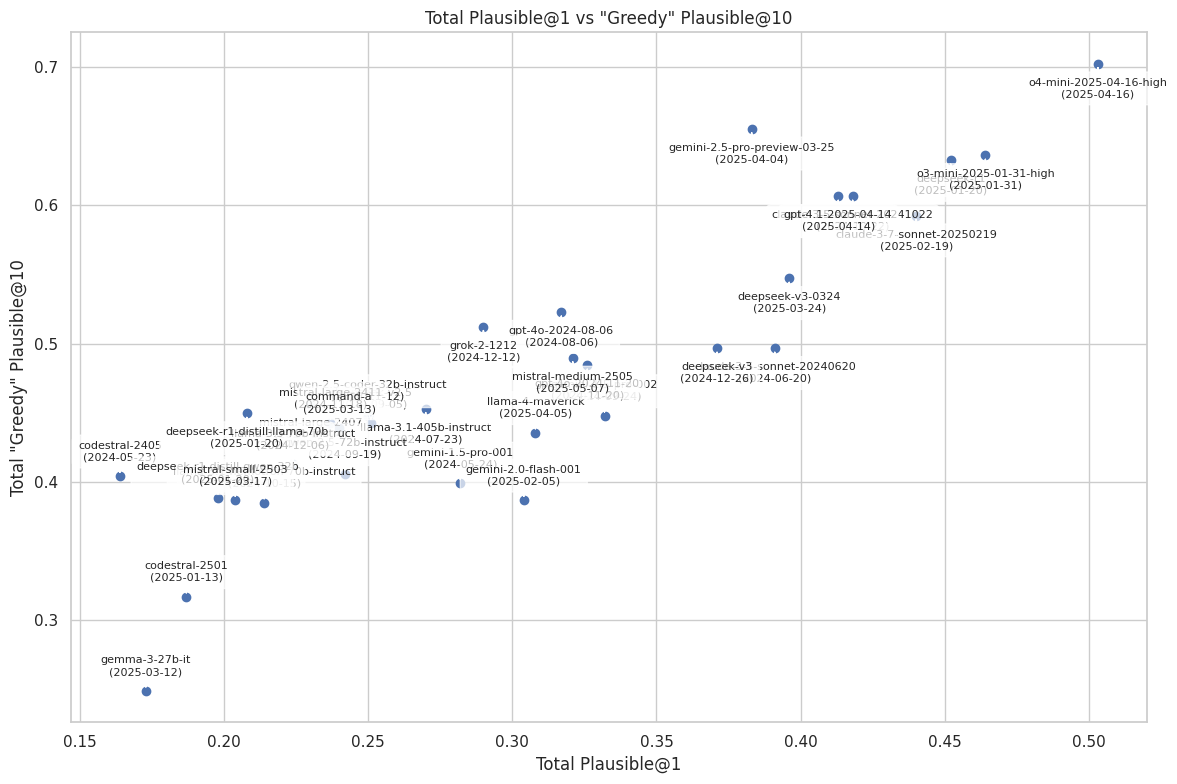

In [6]:
# Create a scatter plot of pass@1 vs "greedy" pass@10
plt.figure(figsize=(12, 8))
scatter = plt.scatter(df['total_plausible@1'], df['total_greedy_plausible@10'])

# Define a dictionary with release dates for each model
with open('../results/release_dates.json') as f:
    release_dates = json.load(f)

# Drop rows with missing data
df_total = df.dropna(subset=['total_plausible@1', 'total_greedy_plausible@10'])

# Add labels for each point with release dates
for i, row in df_total.iterrows():
    model_name = row['name']
    release_date = release_dates.get(model_name, 'N/A')
    
    label = f"{model_name}\n({release_date})"
    x, y = row['total_plausible@1'], row['total_greedy_plausible@10']
    
    # Adjust the position of the label to stay within the plot
    ha = 'center'
    va = 'bottom' if y < df_total['total_greedy_plausible@10'].median() else 'top'
    xytext = (0, 10) if va == 'bottom' else (0, -10)
    
    plt.annotate(label, (x, y), 
                 xytext=xytext, textcoords='offset points', 
                 ha=ha, va=va, fontsize=8, 
                 bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.7),
                 arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

plt.xlabel('Total Plausible@1')
plt.ylabel('Total "Greedy" Plausible@10')
plt.title('Total Plausible@1 vs "Greedy" Plausible@10')

plt.grid(True)

# Adjust the plot layout to make room for annotations
plt.tight_layout()

# Save as pdf
plt.savefig('pass@1-vs-greedy-pass@10.pdf', format='pdf', bbox_inches='tight')
plt.savefig('pass@1-vs-greedy-pass@10.png', format='png', bbox_inches='tight')

plt.show()

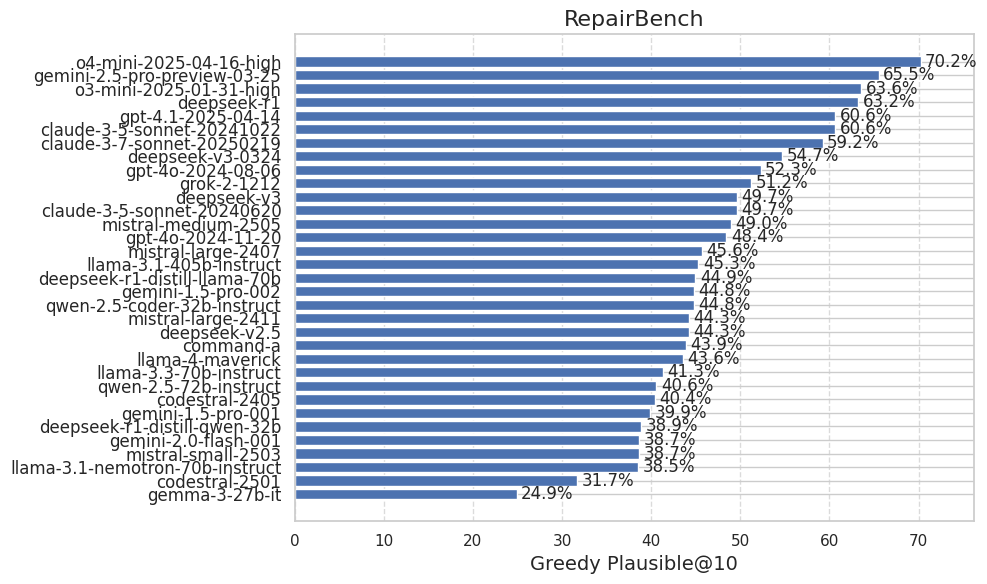

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sort the DataFrame by 'total_greedy_plausible@10' in descending order
df_sorted = df.sort_values(by='total_greedy_plausible@10', ascending=True)

# Remove rows with missing data
df_sorted = df_sorted.dropna(subset=['total_greedy_plausible@10'])

# Set a style
sns.set(style="whitegrid")

# Create a horizontal bar plot with a single color
plt.figure(figsize=(10, 6))
bars = plt.barh(df_sorted['name'], df_sorted['total_greedy_plausible@10'] * 100, align="center", height=0.75)  # Reduced height

# Set labels and title with improved font size and bold text
plt.xlabel('Greedy Plausible@10', fontsize=14)
plt.title('RepairBench', fontsize=16)

# Add text annotations to display the exact score at the end of each bar with some space and bold text
for bar in bars:
    plt.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2, f'{bar.get_width():.1f}%', va='center', fontsize=12)

# Adjust x-axis limits to provide extra space on the right side
plt.xlim(0, df_sorted['total_greedy_plausible@10'].max() * 100 + 6)

# Add a grid for better readability
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Make the names bold
plt.yticks(fontsize=12)

# Adjust layout to make room for the labels
plt.tight_layout()

# Save as pdf
plt.savefig('box-plot-greedy-plausible@10.pdf', format='pdf', bbox_inches='tight')
plt.savefig('box-plot-greedy-plausible@10.png', format='png', bbox_inches='tight')

# Display the plot
plt.show()

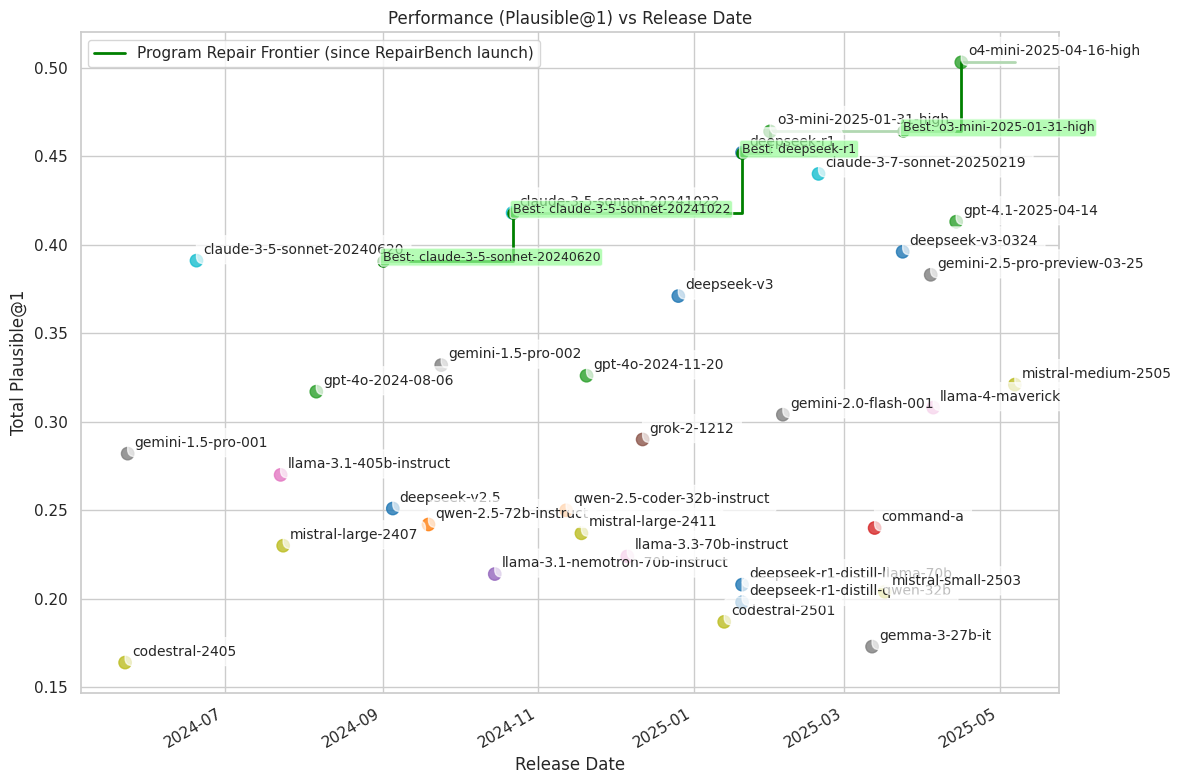

In [8]:
plt.figure(figsize=(12, 8))

# Load release dates
with open('../results/release_dates.json') as f:
    release_dates = json.load(f)

# Drop rows with missing data
df_release = df.dropna(subset=['total_plausible@1'])

# Convert release dates to datetime for plotting
dates = []
scores = []
names = []
providers = []

for i, row in df_release.iterrows():
    model_name = row['name']
    provider = row['provider']
    
    if model_name in release_dates:
        date_str = release_dates[model_name]
        dates.append(pd.to_datetime(date_str))
        scores.append(row['total_plausible@1'])
        names.append(model_name)
        providers.append(provider)
    else:
        print(f"Model {model_name} not found in release dates")

# Create a colormap by provider
unique_providers = list(set(providers))
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_providers)))
provider_to_color = {provider: colors[i] for i, provider in enumerate(unique_providers)}
point_colors = [provider_to_color[provider] for provider in providers]

# Add labels for each point
for i, (date, score, name) in enumerate(zip(dates, scores, names)):
    plt.annotate(name, (date, score), 
                 xytext=(5, 5), textcoords='offset points', 
                 fontsize=10, 
                 bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.7))

# Create the scatter plot
scatter = plt.scatter(dates, scores, c=point_colors, s=80, alpha=0.8)

# Add a legend for providers
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', 
                             markerfacecolor=provider_to_color[provider], markersize=10, 
                             label=provider) for provider in unique_providers]
plt.legend(handles=legend_elements, title="Provider")

# Add a line showing the best model at each timestep
if dates:
    # Convert to pandas Series for easier manipulation
    date_series = pd.Series(scores, index=dates)
    
    # Sort dates chronologically
    date_series = date_series.sort_index()  # Sort by date
    
    # Create a series that tracks the maximum score at each date (considering all previous models)
    all_dates = sorted(date_series.index)
    best_scores = []
    best_models = []
    
    # For each date, find the best model up to that point
    best_score_so_far = float('-inf')
    best_model_so_far = None

    for i, date in enumerate(all_dates):
        # Get all models up to and including this date
        prev_models = date_series[date_series.index <= date]
        if not prev_models.empty:
            current_best_score = prev_models.max()
            
            # Only update if we find a better score (ensure monotonically increasing frontier)
            if current_best_score > best_score_so_far:
                best_score_so_far = current_best_score
                
                # Find which model had this best score
                best_model_date = prev_models[prev_models == current_best_score].index[0]
                model_idx = dates.index(best_model_date)
                best_model_so_far = names[model_idx]
            
            best_scores.append(best_score_so_far)
            best_models.append(best_model_so_far)
    
    # Create a series with all dates and their corresponding best scores
    best_at_date = pd.Series(best_scores, index=all_dates)
    
    # Start the frontier line from September 2024
    start_date = pd.to_datetime('2024-09-01')
    
    # Find the dates after start_date
    valid_dates = [d for d in all_dates if d >= start_date]
    
    if valid_dates:
        # If no date exactly matches start_date, add a point at start_date with the best score from before
        if all_dates[0] < start_date and start_date not in all_dates:
            # Find best model before start_date
            prev_models = date_series[date_series.index < start_date]
            if not prev_models.empty:
                best_score_before = prev_models.max()
                best_model_date = prev_models[prev_models == best_score_before].index[0]
                model_idx = dates.index(best_model_date)
                best_model_name = names[model_idx]
                
                # Add the start date with best performance before it
                best_at_date[start_date] = best_score_before
                best_models.insert(0, best_model_name)
                valid_dates.insert(0, start_date)
        
        # Filter to only show from start_date onwards and sort by date
        frontier_dates = sorted([d for d in best_at_date.index if d >= start_date])
        frontier_series = best_at_date[frontier_dates]
        
        # Ensure frontier is monotonically increasing
        max_val = float('-inf')
        for i, date in enumerate(frontier_dates):
            # Get the current value as a scalar
            current_val = frontier_series.iloc[i]
            if current_val >= max_val:
                max_val = current_val
            else:
                frontier_series.iloc[i] = max_val
     
        # Plot the best score line
        plt.step(frontier_series.index, frontier_series.values, where='post', 
                color='green', linewidth=2, linestyle='-', 
                label='Program Repair Frontier (since RepairBench launch)')
        
        # Add markers and labels at step changes
        prev_val = None
        prev_model = None
        for i, date in enumerate(frontier_dates):
            # Get current value as scalar
            val = frontier_series.iloc[i]
            if i == 0 or val > prev_val:
                # Get the best model at this point
                idx = valid_dates.index(date) + len(best_models) - len(valid_dates) if date in valid_dates else 0
                model_name = best_models[idx]
                
                # Add a marker and label
                plt.plot(date, val, 'o', color='green', markersize=8)
                plt.annotate(f"Best: {model_name}", 
                            (date, val),
                            xytext=(0, 0), 
                            textcoords='offset points',
                            fontsize=9,
                            bbox=dict(boxstyle='round,pad=0.2', fc='palegreen', alpha=0.7))
                prev_val = val

# Update the legend to include the best model line
plt.legend()

plt.xlabel('Release Date')
plt.ylabel('Total Plausible@1')
plt.title('Performance (Plausible@1) vs Release Date')
plt.grid(True)

# Format the x-axis as dates
plt.gcf().autofmt_xdate()

# Adjust the plot layout
plt.tight_layout()

# Save as pdf and png
plt.savefig('plausible-vs-release-date.pdf', format='pdf', bbox_inches='tight')
plt.savefig('plausible-vs-release-date.png', format='png', bbox_inches='tight')

plt.show()